In [3]:
using Plots
using Base: Slice, OneTo
using Random
using StatsBase

# Данные для тестирования

In [7]:
function malanchev_dataset(; inliers=2^10, outliers=2^5)
    s = Float32(0.1)
    return hcat(
        rand(Float32, 2, inliers) ./ 2,
        randn(Float32, 2, outliers) .* s .+ [1; 1],
        randn(Float32, 2, outliers) .* s .+ [0; 1],
        randn(Float32, 2, outliers) .* s .+ [1; 0])
end

malanchev_dataset (generic function with 1 method)

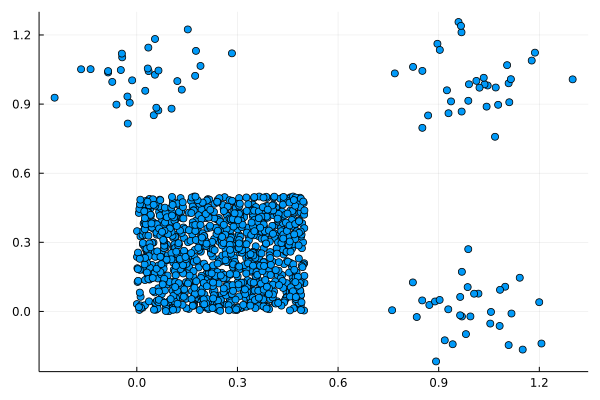

In [53]:
scatter(eachrow(malanchev_dataset())...; legend=nothing)

# Структуры для описания изоляционных деревьев

In [47]:
"Узел дерева. Выбирает фичу индексом feature и по граничному
значению threshold решает, в какую часть поддерева (left или right)
направляться далее.

Случай feature = left = right = 0 зарезервирован для концевого узла.
В этом случае threshold означает длину пути от корневого узла."
mutable struct Node{T}
    feature::Int32
    left::Int32
    right::Int32
    threshold::T
end


"Дерево -- это массив узлов. "
const Tree{T} = Vector{Node{T}}


"Лес -- это массив деревьев. Тут же помним параметры, на основе
которых строились деревья."
struct Forest{T}
    trees::Vector{Tree{T}}
    subsamples::Int
    maxdepth::Int
end


"Вспомогательный тип для view массивов данных при построении деревьев."
const SubData{T} = SubArray{T, 2, Matrix{T}, Tuple{Slice{OneTo{Int64}}, UnitRange{Int}}, true}

SubData

# Оценка средней длины пути в дереве

In [49]:
"Средняя длина пути в дереве из n концевых узлов"
@inline function average_path_length(::Type{T}, n::Int32)::T where T <: Real
    γ = T(MathConstants.γ)
    two = T(2)

    if n <= 2
        return n - 1
    else
        return two * (log(n - 1) + γ) - two * (n - 1) / n
    end
end

average_path_length

# Построение деревьев и выращивание леса

In [50]:
"Построение изоляционного леса. На каждое дерево выполняется выборка
из исходных данных объёмом n_samples. Максимальная глубина дерева при этом
maxdepth, а количество деревьев -- n_trees."
function build_forest(
        data::Matrix{T};
        rng::R=Random.GLOBAL_RNG,
        n_samples::Int,
        n_trees::Int,
        maxdepth::Int32)::Forest{T} where {T <: Real, R <: AbstractRNG}
    
    trees = Vector{Tree{T}}(undef, n_trees)
    
    for i in 1:n_trees
        subsamples = sample(axes(data, 2), n_samples; replace=false)
        subdata = data[:, subsamples]
        
        trees[i] = build_tree!(subdata; rng, maxdepth)
    end

    return Forest{T}(trees, n_samples, maxdepth)
end


"Построение одного дерева, данные по ссылке data при этом модифицируется"
function build_tree!(
        data::Matrix{T};
        rng::R,
        maxdepth::Int32)::Tree{T} where {T <: Real, R <: AbstractRNG}

    tree = Tree{T}(undef, 0)
    view_data = @view data[:, begin:end]
    build_subtree!(view_data, tree, Int32(0), rng; maxdepth)
    return tree
end


"Вспомогательная функция для построения дерева -- построение поддерева."
function build_subtree!(
        subdata::SubData{T},
        tree::Tree,
        depth::Int32,
        rng::R;
        maxdepth::Int32)::Tuple{Int,Int} where {T <: Real, R <: AbstractRNG}
    
    first, last = extrema(axes(subdata, 2))
    n = Int32(last - first + 1)
    if (n < 2) || (depth == maxdepth)
        z = Int32(0)
        push!(tree, Node(z, z, z, depth + average_path_length(T, n)))
        _, root = extrema(axes(tree, 1))
        return (root, root)
    end
    
    feature = Int32(rand(rng, axes(subdata, 1)))
    min, max = extrema(subdata[feature, :])
    threshold = min + rand(rng, T) * (max - min)
    
    z = Int32(0)
    push!(tree, Node(feature, z, z, threshold))
    _, root = extrema(axes(tree, 1))
    
    nextdepth = depth + Int32(1)
    left, right = split_subarray!(subdata, feature, threshold)
    root_left, _ = build_subtree!(left, tree, nextdepth, rng; maxdepth)
    root_right, tip_right = build_subtree!(right, tree, nextdepth, rng; maxdepth)
    
    tree[root].left = root_left
    tree[root].right = root_right

    return (root, tip_right)
end


"Разделить данные pivot'ом на две части -- выше pivot'а и ниже. Модифицирует массив, переставляя внутри."
function split_subarray!(data::SubData{T}, feature::Int32, pivot::T)::Tuple{SubData{T}, SubData{T}} where T <: Real
    left, right = extrema(axes(data, 2))
    while true
        while data[feature, left] < pivot
            left += 1
        end

        while data[feature, right] >= pivot
            right -= 1
        end

        (left < right) || break

        (data[:, left], data[:, right]) = (data[:, right], data[:, left])
    end

    # At the point index `right` is bigger than index `left`
    vleft = @view data[:, begin:right]
    vright = @view data[:, left:end]
    return (vleft, vright)
end

build_subtree! (generic function with 1 method)

# Вычисление "очков" аномальности данных

In [51]:
"Вычисление длины пути от точки sample в дереве tree."
function pathlength(tree::Tree, sample::Vector{T})::T where T <: Real
    index = 1
    feature = tree[index].feature

    while feature != 0
        if sample[feature] < tree[index].threshold
            index = tree[index].left
        else
            index = tree[index].right
        end
        
        feature = tree[index].feature
    end

    return tree[index].threshold
end


"Вычисление осреднённого score по готовому лесу"
function score(forest::Forest, samples::Matrix{T})::Vector{T} where T <: Real
    n_trees = length(forest.trees)

    scores = similar(Vector{T}, (axes(samples, 2),))
    scores[:] .= 0

    for i in eachindex(scores)
        for tree in forest.trees
            scores[i] += pathlength(tree, samples[:, i])
        end

        scores[i] /= n_trees
    end
    
    return -2 .^ (-scores ./ average_path_length(T, Int32(forest.subsamples)))
end

score (generic function with 1 method)

# Пример

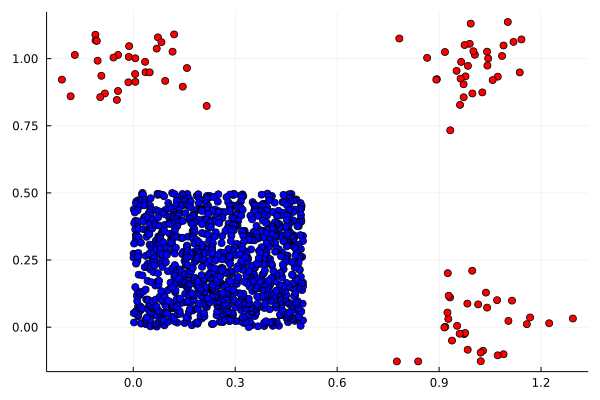

In [52]:
data = malanchev_dataset()
forest = build_forest(data; n_samples=16, n_trees=1000, maxdepth=Int32(4))
scores = score(forest, data)
sorting = sortperm(scores)

scatter(eachrow(data[:, sorting[begin:96]])...; legend=nothing, c=:red)
scatter!(eachrow(data[:, sorting[97:end]])...; legend=nothing, c=:blue)

# Тесты

In [55]:
data = malanchev_dataset(inliers=2^13);

In [60]:
@time isoforest = build_forest(data, n_trees=200, n_samples=1024, maxdepth=Int32(10));

  0.087848 seconds (706.40 k allocations: 84.682 MiB, 14.20% gc time)


In [61]:
@time scores = score(isoforest, data);

  0.542689 seconds (1.66 M allocations: 151.885 MiB, 3.91% gc time)


# Обсуждение

In [85]:
vec = collect(1:10)
@view vec[4:end]

7-element view(::Vector{Int64}, 4:10) with eltype Int64:
  4
  5
  6
  7
  8
  9
 10

In [86]:
@macroexpand @view vec[4:end]

:(true && (view)(vec, 4:(lastindex)(vec)))

In [87]:
view(vec, 4:lastindex(vec))

7-element view(::Vector{Int64}, 4:10) with eltype Int64:
  4
  5
  6
  7
  8
  9
 10

In [83]:
@time isoforest = build_forest(data, n_trees=200, n_samples=1024, maxdepth=Int32(10))

quote
    #= timing.jl:206 =#
    while false
        #= timing.jl:206 =#
    end
    #= timing.jl:207 =#
    local var"#90#stats" = Base.gc_num()
    #= timing.jl:208 =#
    local var"#93#compile_elapsedtime" = Base.cumulative_compile_time_ns_before()
    #= timing.jl:209 =#
    local var"#92#elapsedtime" = Base.time_ns()
    #= timing.jl:210 =#
    local var"#91#val" = (isoforest = build_forest(data, n_trees = 200, n_samples = 1024, maxdepth = Int32(10)))
    #= timing.jl:211 =#
    var"#92#elapsedtime" = Base.time_ns() - var"#92#elapsedtime"
    #= timing.jl:212 =#
    var"#93#compile_elapsedtime" = Base.cumulative_compile_time_ns_after() - var"#93#compile_elapsedtime"
    #= timing.jl:213 =#
    local var"#94#diff" = Base.GC_Diff(Base.gc_num(), var"#90#stats")
    #= timing.jl:214 =#
    Base.time_print(var"#92#elapsedtime", (var"#94#diff").allocd, (var"#94#diff").total_time, Base.gc_alloc_count(var"#94#diff"), var"#93#compile_elapsedtime", true)
    #= timing.jl:215 =#
    var"#91

In [74]:
using Profile

In [75]:
@profile scores = score(isoforest, data);

In [76]:
Profile.print()

Overhead ╎ [+additional indent] Count File:Line; Function
   1╎1    ...multidimensional.jl:847; _unsafe_getindex(::IndexLinear,...
    ╎1384 @Base/task.jl:411; (::IJulia.var"#15#18")()
    ╎ 1384 ...lia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
    ╎  1384 @Base/essentials.jl:706; invokelatest
    ╎   1384 @Base/essentials.jl:708; #invokelatest#2
    ╎    1384 ...execute_request.jl:67; execute_request(socket::ZMQ.S...
    ╎     1384 ...SoftGlobalScope.jl:65; softscope_include_string(m::...
    ╎    ╎ 1384 @Base/loading.jl:1094; include_string(mapexpr::typ...
   2╎    ╎  1384 @Base/boot.jl:360; eval
   4╎    ╎   1374 In[51]:27; score(forest::Forest{Float...
  27╎    ╎    27   In[51]:0; pathlength(tree::Vector{N...
    ╎    ╎    85   In[51]:3; pathlength(tree::Vector{N...
   2╎    ╎     2    In[51]:1; getindex
  83╎    ╎     83   @Base/array.jl:801; getindex
 499╎    ╎    499  In[51]:5; pathlength(tree::Vector{N...
  55╎    ╎    97   In[51]:6; pathlength(tree::Vector{N...
  10╎  

In [80]:
@code_lowered score(isoforest, data)

CodeInfo(
1 ─ %1  = Core.apply_type(Main.Vector, $(Expr(:static_parameter, 1)))
│   %2  = Base.getproperty(forest, :trees)
│         n_trees = Main.length(%2)
│   %4  = Core.apply_type(Main.Vector, $(Expr(:static_parameter, 1)))
│   %5  = Main.axes(samples, 2)
│   %6  = Core.tuple(%5)
│         scores = Main.similar(%4, %6)
│   %8  = Base.dotview(scores, Main.:(:))
│   %9  = Base.broadcasted(Base.identity, 0)
│         Base.materialize!(%8, %9)
│   %11 = Main.eachindex(scores)
│         @_4 = Base.iterate(%11)
│   %13 = @_4 === nothing
│   %14 = Base.not_int(%13)
└──       goto #7 if not %14
2 ┄ %16 = @_4
│         i = Core.getfield(%16, 1)
│   %18 = Core.getfield(%16, 2)
│   %19 = Base.getproperty(forest, :trees)
│         @_7 = Base.iterate(%19)
│   %21 = @_7 === nothing
│   %22 = Base.not_int(%21)
└──       goto #5 if not %22
3 ┄ %24 = @_7
│         tree = Core.getfield(%24, 1)
│   %26 = Core.getfield(%24, 2)
│   %27 = Base.getindex(scores, i)
│   %28 = tree
│   %29 = Base.getindex(